In [0]:
# !pip install torch torchvision

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np

import seaborn as sns 

In [5]:
#setting up the data
!wget 'https://storage.googleapis.com/mledu-datasets/california_housing_train.csv'

df= pd.read_csv('california_housing_train.csv')
# df
# np.array([df.iloc[6, 1:]]).astype('float')

df.describe()

--2019-08-18 10:33:52--  https://storage.googleapis.com/mledu-datasets/california_housing_train.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1706430 (1.6M) [application/octet-stream]
Saving to: ‘california_housing_train.csv’

california_housing_ 100%[===================>]   1.63M  --.-KB/s    in 0.01s   

2019-08-18 10:33:52 (168 MB/s) - ‘california_housing_train.csv’ saved [1706430/1706430]



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


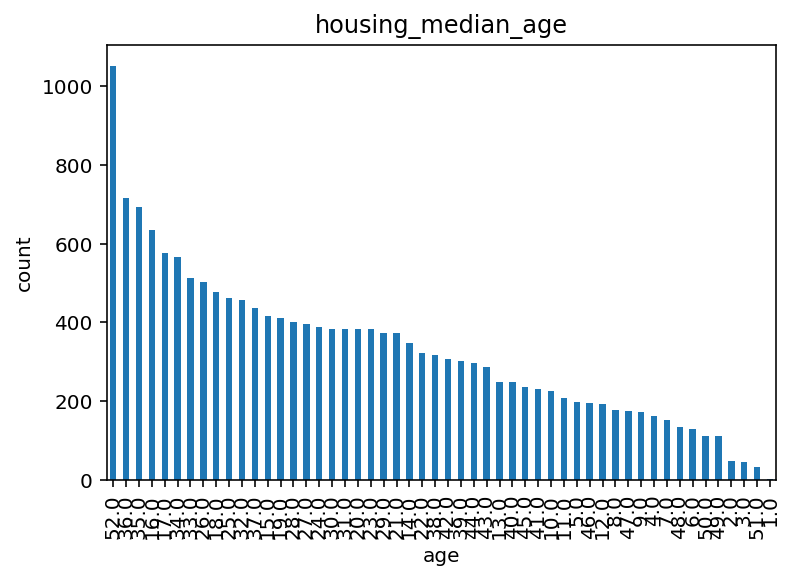

In [6]:
df['housing_median_age'].value_counts().plot(kind='bar')
plt.title('housing_median_age')
plt.xlabel('age')
plt.ylabel('count')
plt.show()

<Figure size 720x720 with 0 Axes>

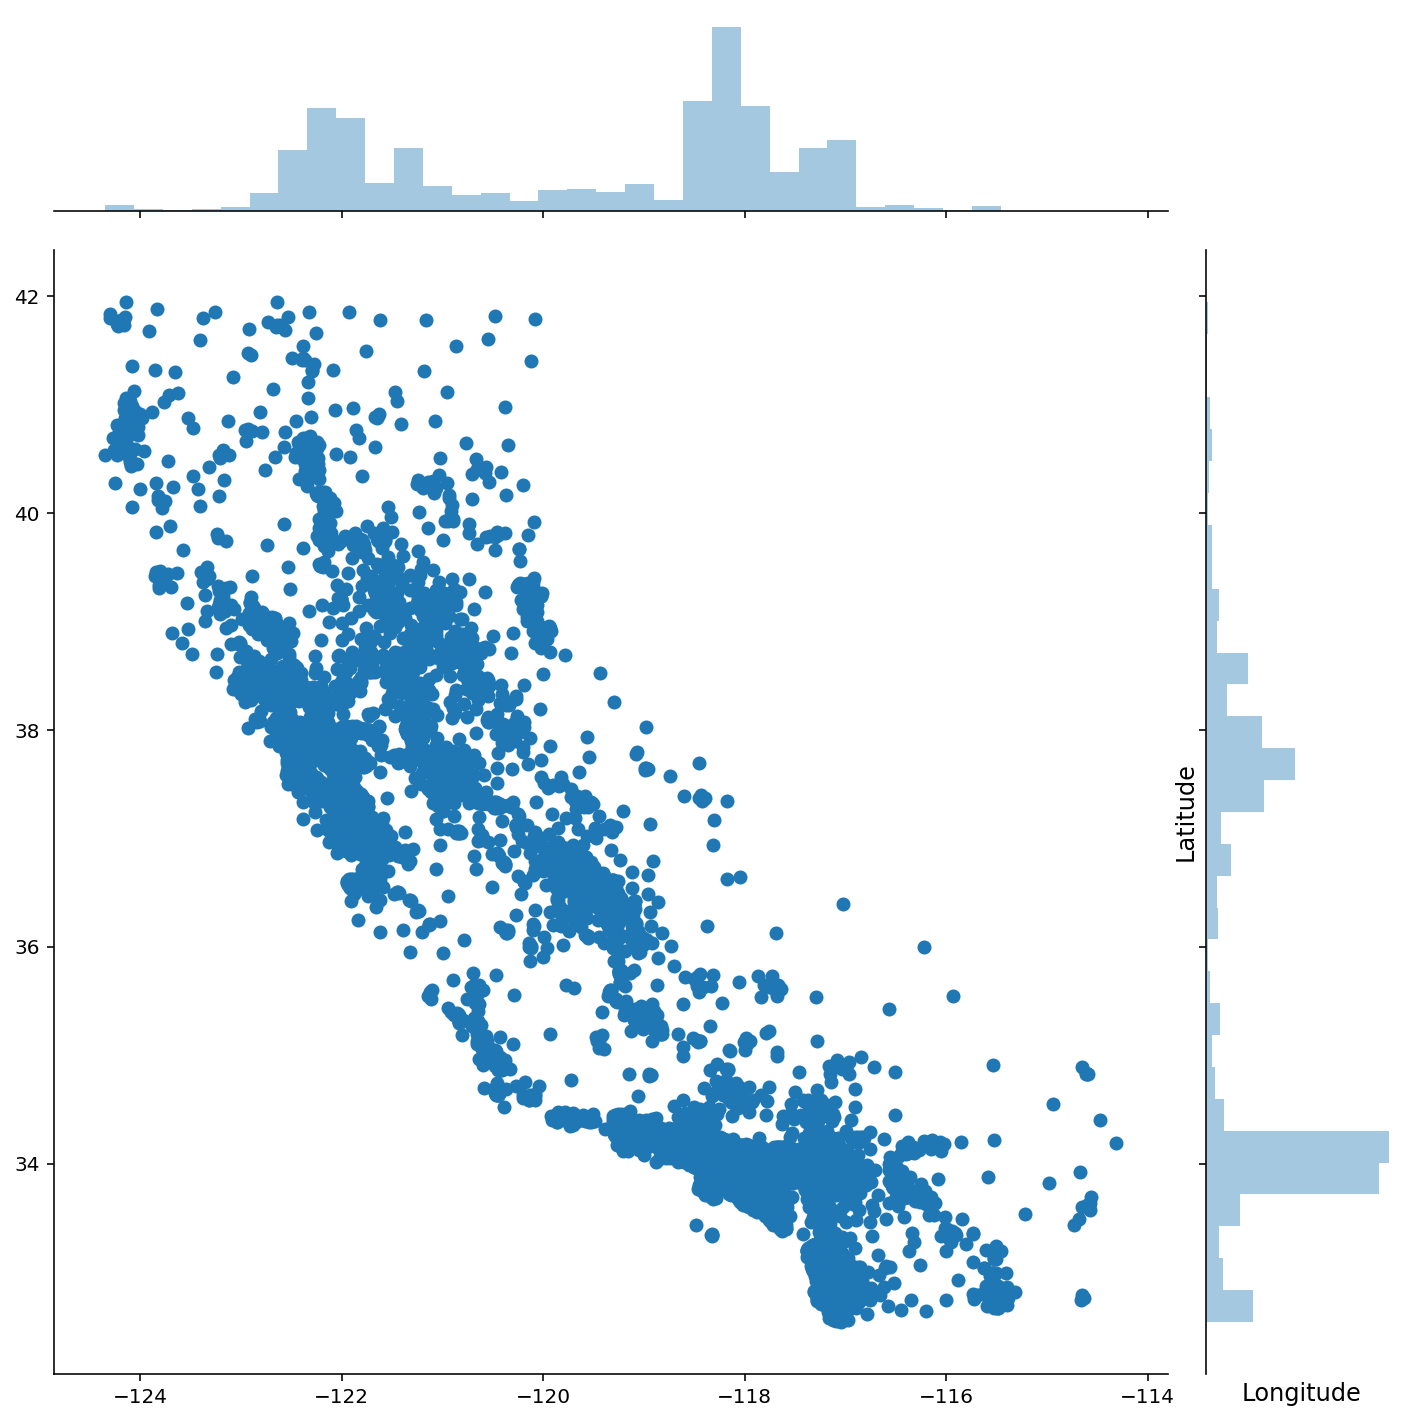

<function seaborn.utils.despine>

In [7]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df.longitude.values, y=df.latitude.values, height=10)

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()
sns.despine

Text(0, 0.5, 'Rooms')

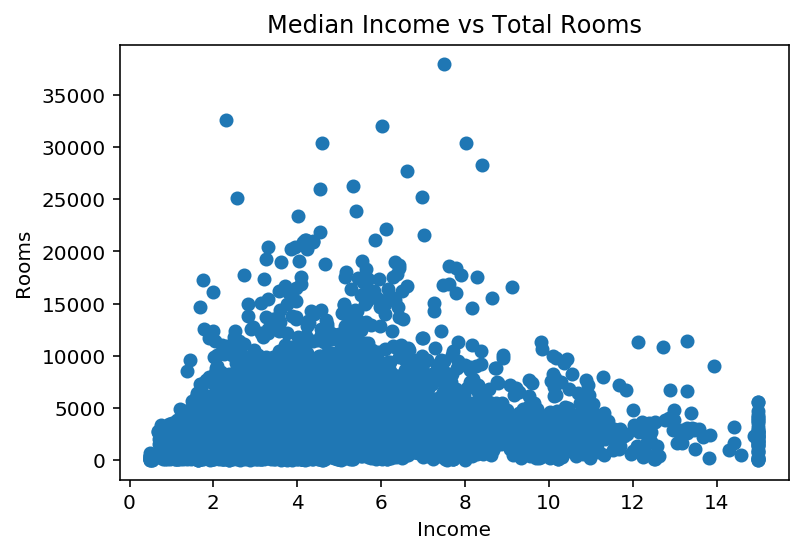

In [10]:
plt.scatter(df.median_income, df.total_rooms)
plt.title("Median Income vs Total Rooms")
plt.xlabel('Income')
plt.ylabel('Rooms')

In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

# labels = df['total_rooms']
# conv_rooms = [1 if values == 2014 else 0 for values in data.date ]
# data['date'] = conv_rooms
# train1 = data.drop(['id', 'price'],axis=1)

In [0]:
class HousingDataset():
    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.housing_frame = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.housing_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        housings = self.housing_frame.iloc[idx, 1:]
        housings = np.array([housings]).astype('float')

        return housings

In [53]:
house_dataset = HousingDataset(csv_file='california_housing_train.csv')

t_size = int(0.8 * len(house_dataset))

train_size = int(0.8 * t_size)
val_size = int(0.2 * t_size)
test_size = len(house_dataset) - t_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(house_dataset, [train_size, val_size, test_size])

len(train_dataset), len(val_dataset), len(test_dataset)

(10880, 2720, 3400)

In [64]:
#Downloading and setting up the datas
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

ValueError: ignored

In [0]:
def update_classwise_accuracies(preds,labels,class_correct,class_totals):

    correct = np.squeeze(preds.eq(labels.data.view_as(preds)))
    for i in range(labels.shape[0]):
        label = labels.data[i].item()
        class_correct[label] += correct[i].item()
        class_totals[label] += 1

In [0]:
class Network(nn.Module):
    def __init__(self,device=None):
      super().__init__()
      if device is not None:
          self.device = device
      else:
          self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
          
    def forward(self,x):
      pass
    
    def set_model_params(self, lr, dropout_p, class_names):

        self.criterion = nn.NLLLoss()
        self.optimizer = optim.SGD(self.parameters(),lr=lr)
        self.lr = lr
        self.dropout_p = dropout_p
        self.class_names = class_names

    def validate_(self,validloader):
        running_loss = 0.
        accuracy = 0
        class_correct = defaultdict(int)
        class_totals = defaultdict(int)
        self.eval()
        with torch.no_grad():
            for inputs, labels in validloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.forward(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, preds = torch.max(torch.exp(outputs), 1)
                update_classwise_accuracies(preds,labels,class_correct,class_totals)
                accuracy = (100*np.sum(list(class_correct.values()))/np.sum(list(class_totals.values())))
                self.train()
                return (running_loss/len(validloader),accuracy)
    
    def train_(self,trainloader,criterion,optimizer,print_every):
      self.train()
#       t0 = time.time()
      batches = 0
      running_loss = 0
      for inputs, labels in trainloader:
        batches += 1
#         t1 = time.time()

        inputs, labels = inputs.to(self.device), labels.to(self.device)
        optimizer.zero_grad()
        outputs = self.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        #print('training this batch took {:.3f} seconds'.format(time.time() - t1))
        running_loss += loss
        if batches % print_every == 0:
            print(f"{time.asctime()}.."
                    f"Time Elapsed = {time.time()-t0:.3f}.."
                    f"Batch {batches+1}/{len(trainloader)}.. "
                    f"Average Training loss: {running_loss/(batches):.3f}.. "
                    f"Batch Training loss: {loss:.3f}.. "
                    )
        t0 = time.time()
        return running_loss/len(trainloader)  

In [0]:
model = nn.Sequential(nn.Linear(784,128),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1))

In [0]:
max_epochs = 2

for epoch in range(max_epochs):
  for i in range(len(house_dataset)):
    housing_item = torch.from_numpy(house_dataset[i])
    
    print(housing_item)